### Notebook to configure model

In [21]:
import time
import math
import copy

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context(context="talk")

import torch
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils import data


In [22]:
isRetrain = False

# Hyperparameter

QUERY_SIZE = 10
EMBEDDING_SIZE = 100

# HIDDEN_SIZE = 512
# ATTENTION_SIZE = 64

LEARNING_RATE = 1e-3
BATCH_SIZE = 256

VOCAB_SIZE = 5
NUM_CLASSES = 2

# Data-specific

READ_LENGTH = 10

GENOME_START = 0
GENOME_END = 99

GENOME_LENGTH = GENOME_END - GENOME_START + 1   # 205438
CONTEXT_SIZE = GENOME_LENGTH

ref_names = ["class", "ref", "sequence"]
VOCAB = ['N','A','T','C','G']


In [23]:
def load_ref_data(file_name, sample_ratio= 1, n_class=2, names=ref_names):
    
    csv_file = pd.read_csv(file_name, names=ref_names)
    shuffle_csv = csv_file.sample(frac=sample_ratio).reset_index()
#     x = pd.Series(shuffle_csv["sequence"])
    x = list(shuffle_csv["sequence"])
#     ref = pd.Series(shuffle_csv["ref"])
    ref = list(shuffle_csv["ref"])
    y = pd.Series(shuffle_csv["class"])
    y = to_one_hot(y, n_class)
    print(y.shape)
#     print(type(x))
#     print(type(y))
#     print(type(ref))

    return x, ref, y


In [24]:
def create_synthetic_data(file_name, cancer_genes, benign_genes, cancer_cnv=None, benign_cnv=None, num_patients=10, num_reads_per_patients=3, read_length=READ_LENGTH, genome_length=GENOME_LENGTH, vocab=VOCAB, isSomatic=True, print_seq=False):
    
    seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    backup_seq_list = seq_list
    
    for loc, mutation in cancer_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]        
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)

    if cancer_cnv != None:
        for cnv, prob in cancer_cnv.items():
            switch = np.random.choice(num_patients*num_reads_per_patients, int(num_patients*num_reads_per_patients*prob))
            locs[switch] = cnv      
    
    file = open('./tumor-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./tumor-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1, %d, %s\n" % (locs[r], reads[r]))
    file.close()
    
    tumor_locs = locs
    tumor_reads = reads

    if isSomatic:
        seq_list = backup_seq_list
    else:
        seq_list = np.random.choice(vocab, [num_patients, genome_length], replace=True)
    
    for loc, mutation in benign_genes.items():
        seq_list[np.random.choice(num_patients, int(num_patients*mutation[1]), replace=False), loc] = mutation[0]
    
    genomes = []
    for r in range(seq_list.shape[0]):
        seq = ''.join(seq_list[r,:])
        if print_seq:
            print(seq)
        genomes.append(seq)

    locs = np.random.choice(genome_length-read_length, num_patients*num_reads_per_patients)
    
    if benign_cnv != None:
        for cnv, prob in benign_cnv.items():
            switch = np.random.choice(num_patients*num_reads_per_patients, int(num_patients*num_reads_per_patients*prob))
            locs[switch] = cnv 
        
    file = open('./normal-genome-'+file_name+'.txt','w')
    count = 0
    reads = []
    for genome in genomes:
        for t in range(num_reads_per_patients):
            index = count*num_reads_per_patients+t
            reads.append(genome[locs[index]:locs[index]+read_length])
        file.write("%s\n" % genome)
        count = count + 1
    file.close() 

    file = open('./normal-syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("0, %d, %s\n" % (locs[r], reads[r]))
    file.close() 
    
    normal_locs = locs
    normal_reads = reads
    
    file = open('./syn-'+file_name+'.csv','w')
    for r in range(num_patients*num_reads_per_patients):
        file.write("1,%d,%s\n" % (tumor_locs[r], tumor_reads[r]))
        file.write("0,%d,%s\n" % (normal_locs[r], normal_reads[r]))
    file.close() 
    
    return './syn-'+file_name+'.csv'
    


In [25]:
def to_one_hot(y, n_class):
    
    return np.eye(n_class)[y.astype(int)]


In [26]:
def split_ref_dataset(x_test, y_test, ref_test, dev_ratio):

    test_size = len(x_test)
    print(test_size)
    dev_size = (int)(test_size * dev_ratio)
    print(dev_size)

    x_dev = x_test[:dev_size]
    x_test = x_test[dev_size:]
    y_dev = y_test[:dev_size]
    y_test = y_test[dev_size:]
    ref_dev = ref_test[:dev_size]
    ref_test = ref_test[dev_size:]

    return x_test, x_dev, y_test, y_dev, ref_test, ref_dev, dev_size, test_size - dev_size


In [27]:
class TensorizedReadDataset(torch.utils.data.DataLoader):
    'Characterizes a Tensorized dataset for genome reads in PyTorch'
    
    def __init__(self, reads, ref_locs, labels, read_length=100, genome_start=0, genome_end=0):
#         super(TensorizedReadDataset, self).__init__()
        
        self.read_length = read_length
        self.labels = labels
        self.reads = reads
        self.ref_locs = ref_locs
        self.genome_start = genome_start
        self.genome_end = genome_end

    def __len__(self):
        return len(self.reads)

    def __getitem__(self, index):
        
        vals = list(self.reads[index])[0:self.read_length]        
        locs = list(np.arange(self.ref_locs[index]-self.genome_start,self.ref_locs[index]+self.read_length-self.genome_start))

#         print(len(vals))
#         print(len(locs))
        
        vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}
#         read = torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int), requires_grad=False)

        read = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(vals, locs)], dtype=int)), requires_grad=False)
        
        X = read
        Y = self.labels[index,:]

#         torch.LongTensor(self.labels[index,:])

        return X, Y
    

In [28]:
class SequenceAttentionClassifier(nn.Module):
    
    def __init__(self, genome_length, vocab_size=5, query_size=10, embedding_size=128, num_classes=2):
        
        super(SequenceAttentionClassifier, self).__init__()
        
        self.genome_length = genome_length
        self.vocab_size = vocab_size
        self.query_size = query_size
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.K = nn.Embedding(vocab_size*genome_length, embedding_size)
        self.V = nn.Embedding(vocab_size*genome_length, query_size)
        self.W = nn.Linear(query_size, num_classes)
        self.Q = nn.Linear(embedding_size, query_size)
        
    def forward(self, read):
        
        # 'read' here should be mapped to a flattened form where X_ij = 1 maps to i*vocab_size + j
        K_lookup = self.K(read) # Get the relevant keys
        V_lookup = self.V(read) # Get the relevant values

        # Get the attention weights
        logits = self.Q(K_lookup) / math.sqrt(self.embedding_size)
        probs = F.softmax(logits, dim = -1)
        
        # Calculate the covariates for the logistic regression
#         X = torch.matmul(probs.transpose(1,2), V_lookup)
#         X = probs * V_lookup
        X = (probs * V_lookup).sum(dim=1)

        # Right now we can just ignore the fact that we're doing a linear-transform.
        # In the future we'll add nonlinearities

        # Return the logits for the classifier
        return self.W(X)
    

In [29]:
# load data

# cancer_genes = {5 :['A',0.95], 
#                 8 :['G',0.8],
#                 30:['T',1],
#                 31:['G',1],
#                 50:['A',0.6],
#                 55:['G',0.7],
#                 60:['G',1],
#                 70:['C',0.85],
#                 90:['C',1],
#                 95:['N',1]}
# benign_genes = {10:['C',0.99],
#                 11:['G',0.98],
#                 12:['T',1],
#                 53:['A',0.9],
#                 80:['G',0.85]}

# num_patients = 10
# num_reads_per_patients = 5000
# read_length = 10
# file_name = 'p10-t5000-r10-somatic'

# syn_file = create_synthetic_data(file_name, cancer_genes, benign_genes, None, None, num_patients, num_reads_per_patients, read_length, isSomatic=True)
# print(syn_file)

# x_train, refs_train, y_train = load_ref_data(syn_file, sample_ratio=1)


# # split dataset to test and dev
# x_train, x_test, y_train, y_test, refs_train, refs_test, test_size, train_size = \
#     split_ref_dataset(x_train, y_train, refs_train, 0.005)
    
# print("Validation size: ", test_size)
# print("Training size: ", train_size)


In [30]:
# ## Generators
# train_dataset = TensorizedReadDataset(reads=x_train, 
#                                       ref_locs=refs_train, 
#                                       labels=y_train, 
#                                       read_length=READ_LENGTH, 
#                                       genome_start=GENOME_START, 
#                                       genome_end=GENOME_END)

# test_dataset = TensorizedReadDataset(reads=x_test, 
#                                         ref_locs=refs_test, 
#                                         labels=y_test, 
#                                         read_length=READ_LENGTH, 
#                                         genome_start=GENOME_START, 
#                                         genome_end=GENOME_END)


# # Input pipeline
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                              batch_size=BATCH_SIZE,
#                                              shuffle=True)


In [31]:
# model = SequenceAttentionClassifier(genome_length=GENOME_LENGTH,
#                                     vocab_size=VOCAB_SIZE,
#                                     query_size=QUERY_SIZE,
#                                     embedding_size=EMBEDDING_SIZE,
#                                     num_classes=NUM_CLASSES)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# if isRetrain:
#     model.load_state_dict(torch.load('./dummy_'+file_name+'_model.pth'))

In [32]:
# num_epochs = 40

# # Training process
# for epoch in range(num_epochs):
#     b = 0 # count batch
#     for x_batch, y_batch in train_loader:
        
#         optimizer.zero_grad()
        
#         outputs = model(x_batch) 
        
# #         loss = criterion(outputs, y_batch) 
#         loss = criterion(outputs, torch.max(y_batch.type(torch.LongTensor), 1)[1])

#         loss.backward()
#         optimizer.step()
        
#         if (b + 1) % 10 == 0:
#             print("Epoch {}, Batch {}, loss :{}".format(epoch + 1, b + 1, loss.data[0]))
#         b = b + 1
            

In [33]:
# torch.save(model, './full_dummy_'+file_name+'_model.pt')
# torch.save(model.state_dict(), './dummy_'+file_name+'_model.pth')


In [34]:
# Validation process

# correct = 0
# total = 0
# for x_batch, y_batch in test_loader:
#     outputs = model(x_batch)
#     _, predicted = torch.max(outputs.data, 1)
#     total += y_batch.size(0)
#     correct += (predicted == torch.max(y_batch.type(torch.LongTensor), 1)[1]).sum()

# print('Validation Accuracy: {}%'.format(100 * correct / total))    


In [35]:
# model = torch.load('../full_dummy_'+file_name+'_model.pt')
# model.load_state_dict(torch.load('../dummy_'+file_name+'_model.pth'))

file_name = 'p1000-t1000-r50-somatic'
model = torch.load('./full_dummy_'+file_name+'_model.pt')

In [36]:
genome_locs = list(np.arange(0,GENOME_LENGTH))
vals2idx = {'N': 0, 'A': 1, 'C': 2, 'T': 3, 'G': 4}

genome_N_vals = ['N'] * GENOME_LENGTH
genome_A_vals = ['A'] * GENOME_LENGTH
genome_C_vals = ['C'] * GENOME_LENGTH
genome_T_vals = ['T'] * GENOME_LENGTH
genome_G_vals = ['G'] * GENOME_LENGTH

genome_N = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_N_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_A = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_A_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_C = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_C_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_T = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_T_vals, genome_locs)], dtype=int)), requires_grad=False)
genome_G = torch.autograd.Variable(torch.LongTensor(np.array([vals2idx[val]+loc*len(vals2idx) for val, loc in zip(genome_G_vals, genome_locs)], dtype=int)), requires_grad=False)



In [54]:
# for plotting

q_size = model.query_size
# q_size = 1
point_size = 200
alpha_value = 1
width = 40
height = 5

torch.Size([100, 10])
torch.Size([100, 2])


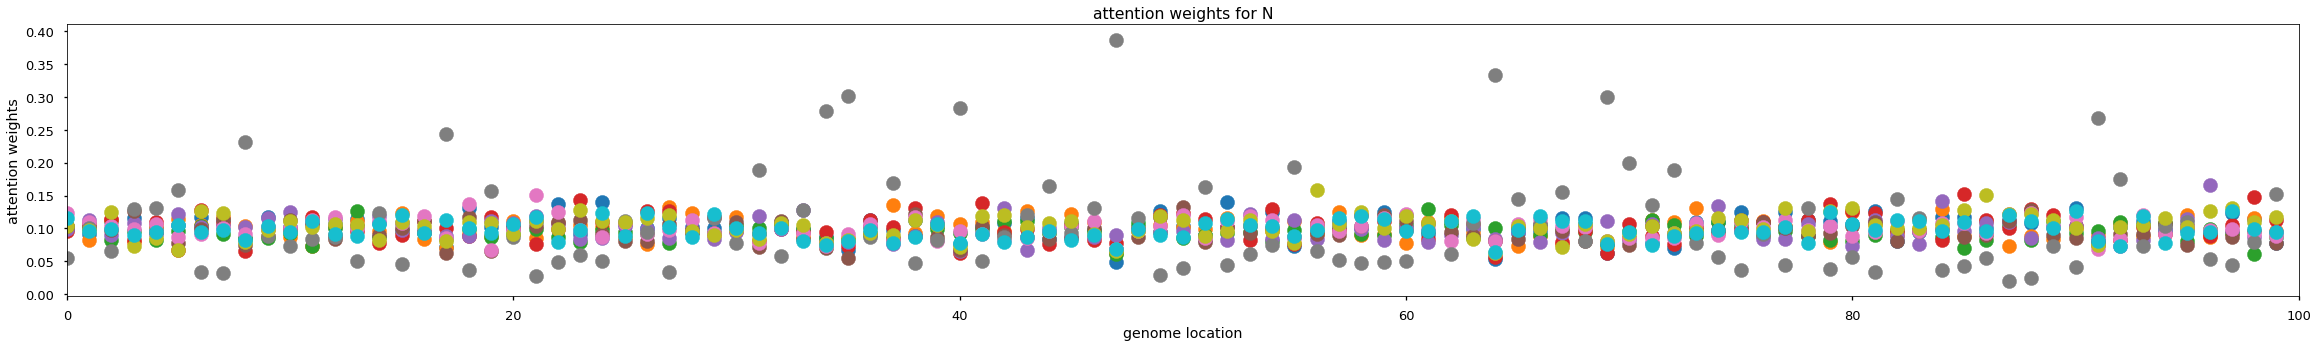

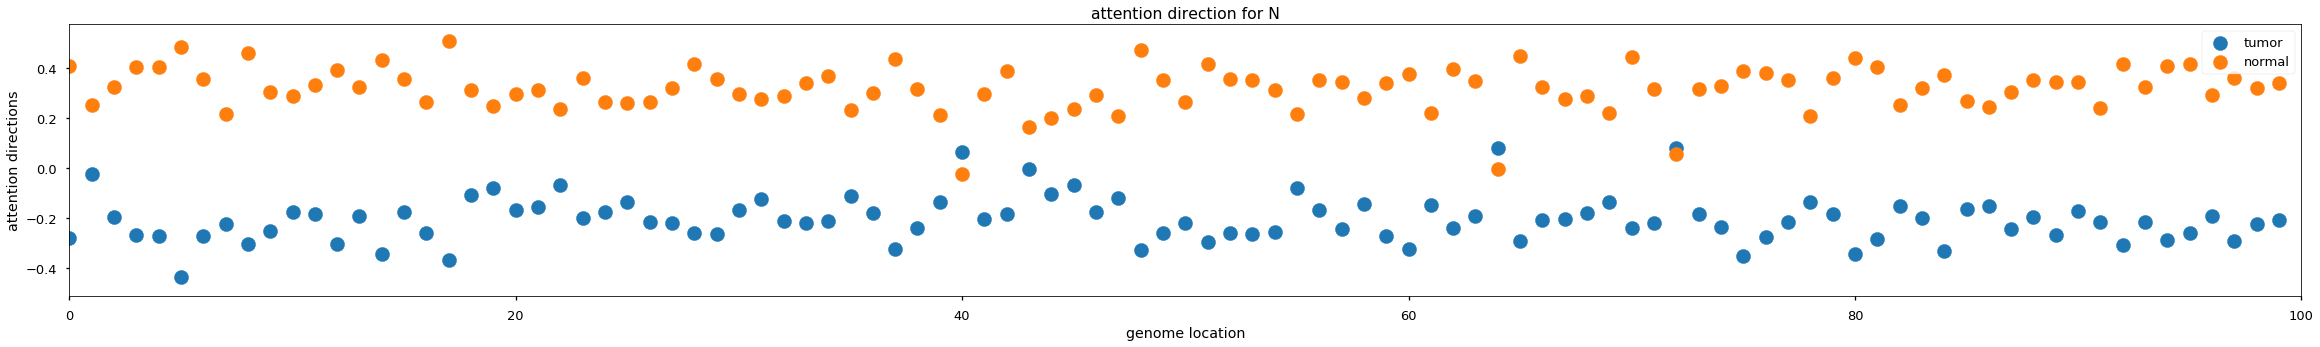

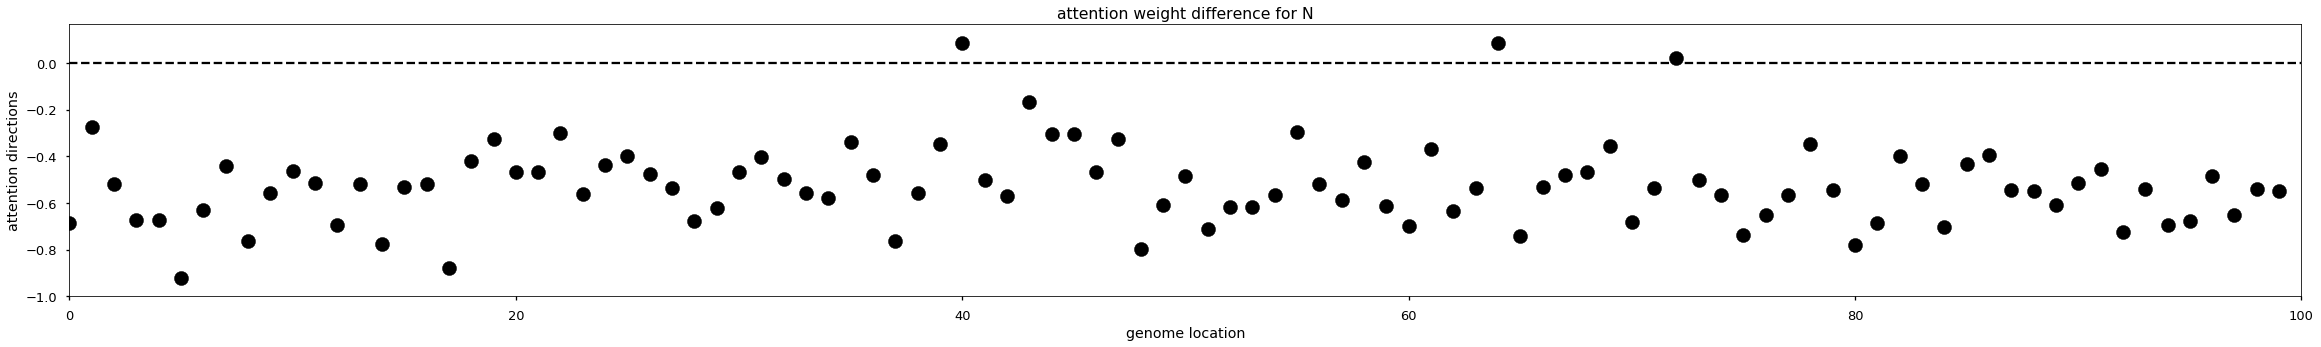

In [57]:
K_lookup_N = model.K(genome_N) 
V_lookup_N = model.V(genome_N) 
logits_N = model.Q(K_lookup_N) / math.sqrt(model.embedding_size)
probs_N = F.softmax(logits_N, dim = -1)    
X_N = probs_N * V_lookup_N
Y_N = model.W(X_N)

print(probs_N.shape)
print(Y_N.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_N.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for N')
plt.savefig('./N-attn-'+file_name+'.png')
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for N')
plt.savefig('./N-dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_N.data[:,0]-Y_N.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for N')
plt.axhline(y=0,ls='dashed',c='black')
plt.savefig('./N-diff-'+file_name+'.png')
plt.show()


torch.Size([100, 10])
torch.Size([100, 2])


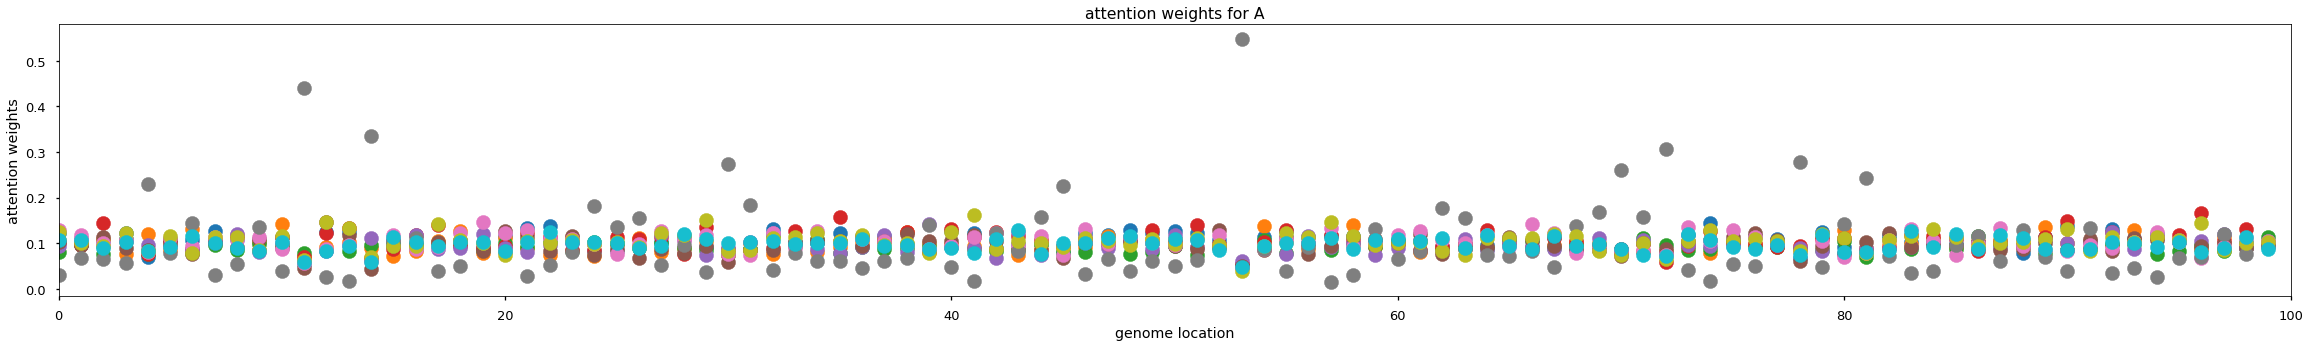

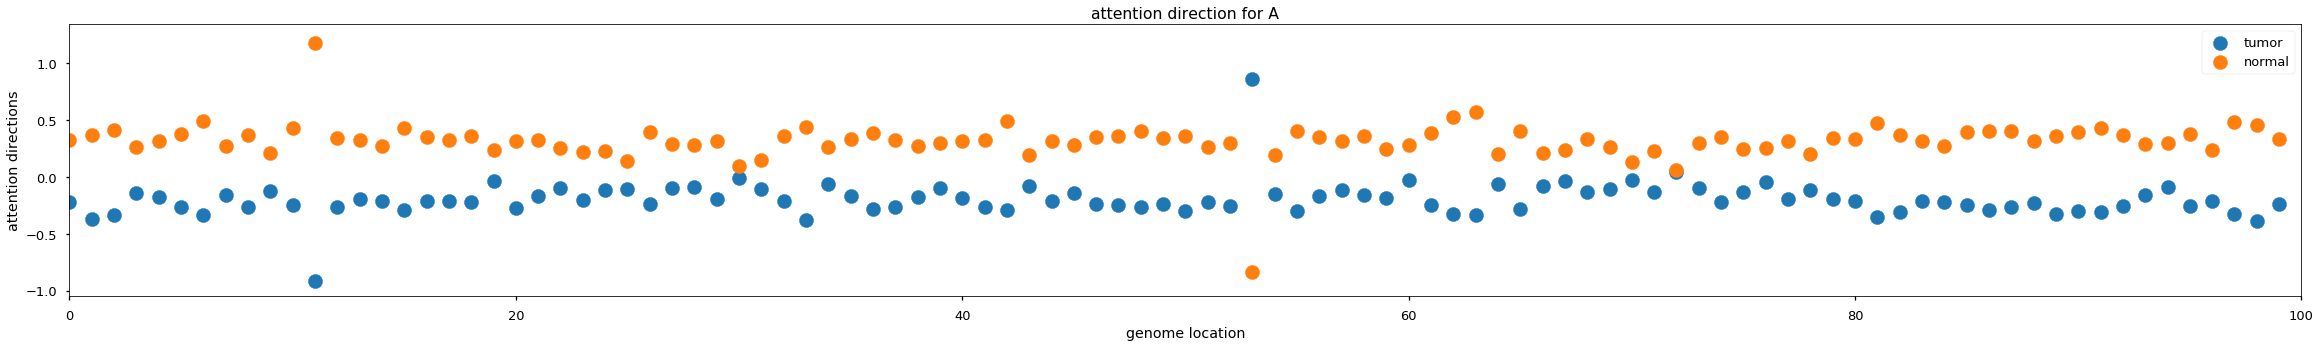

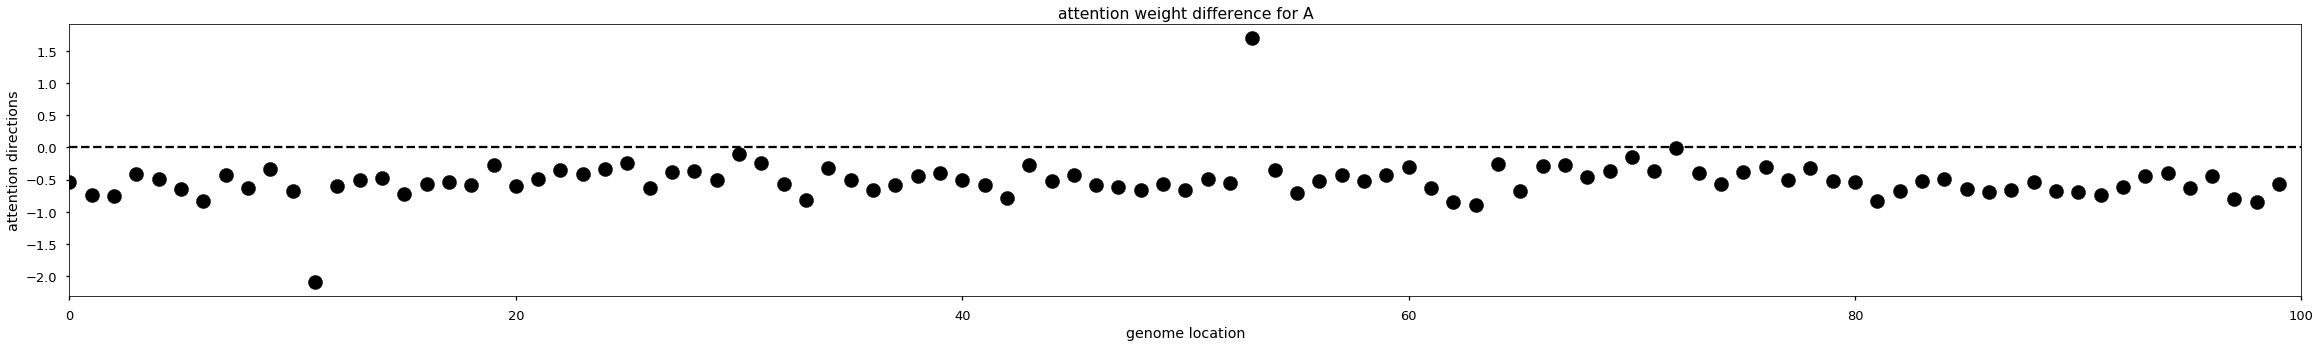

In [58]:
K_lookup_A = model.K(genome_A) 
V_lookup_A = model.V(genome_A) 
logits_A = model.Q(K_lookup_A) / math.sqrt(model.embedding_size)
probs_A = F.softmax(logits_A, dim = -1)    
X_A = probs_A * V_lookup_A
Y_A = model.W(X_A)

print(probs_A.shape)
print(Y_A.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_A.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for A')
plt.savefig('./A-attn-'+file_name+'.png')
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for A')
plt.savefig('./A-dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_A.data[:,0]-Y_A.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for A')
plt.axhline(y=0,ls='dashed',c='black')
plt.savefig('./A-diff-'+file_name+'.png')
plt.show()



torch.Size([100, 10])
torch.Size([100, 2])


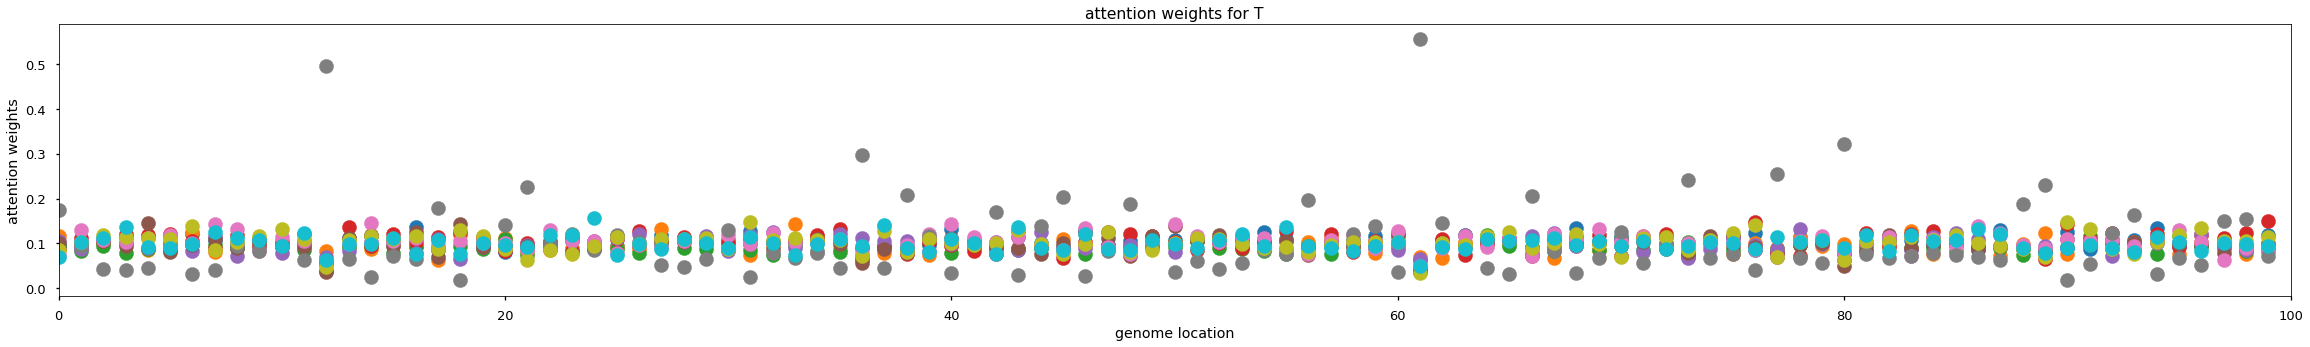

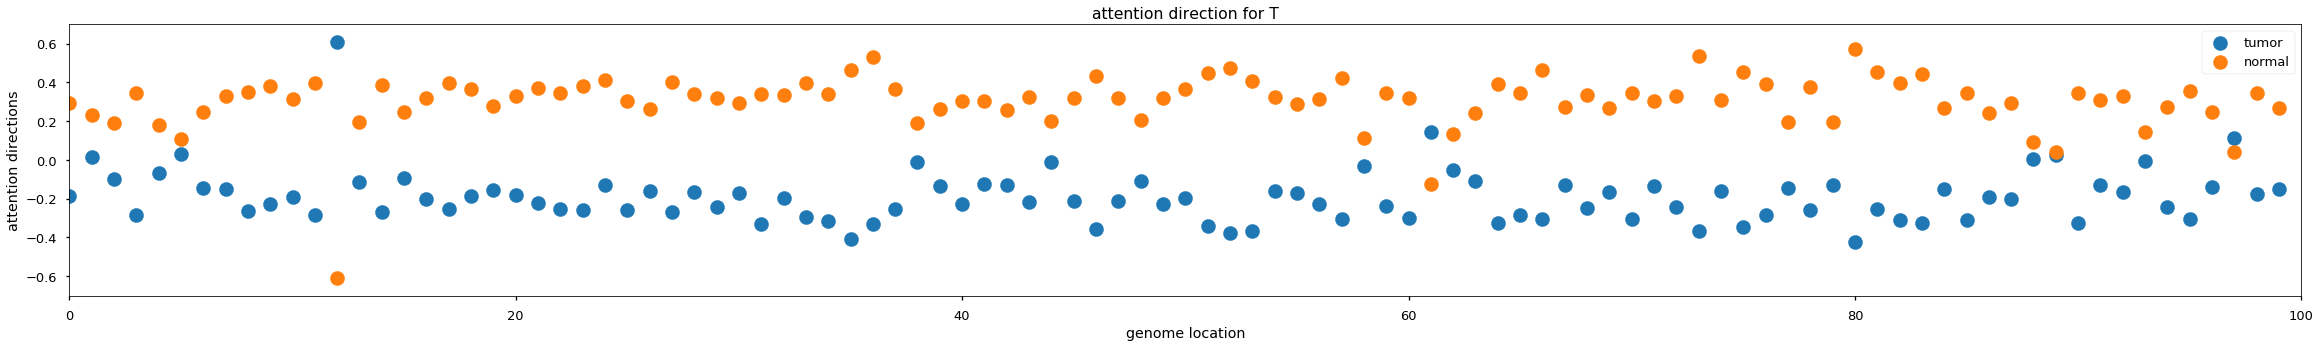

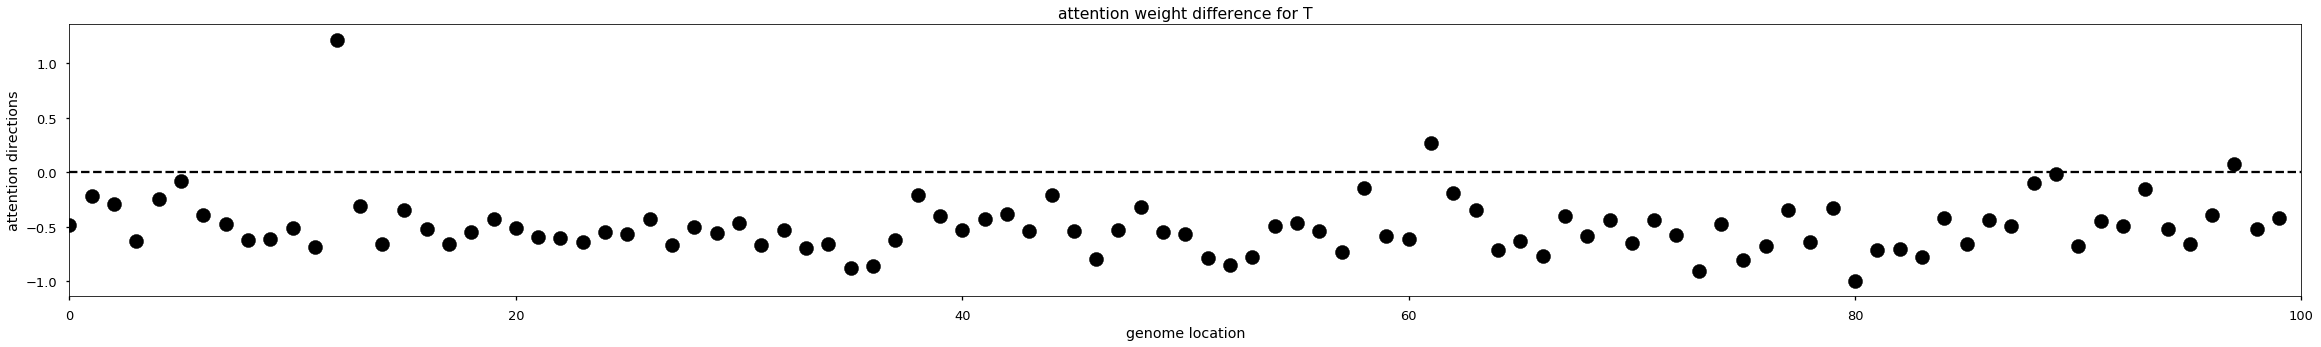

In [59]:
K_lookup_T = model.K(genome_T) 
V_lookup_T = model.V(genome_T) 
logits_T = model.Q(K_lookup_T) / math.sqrt(model.embedding_size)
probs_T = F.softmax(logits_T, dim = -1)    
X_T = probs_T * V_lookup_T
Y_T = model.W(X_T)

print(probs_T.shape)
print(Y_T.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_T.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for T')
plt.savefig('./T-attn-'+file_name+'.png')
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for T')
plt.savefig('./T-dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_T.data[:,0]-Y_T.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for T')
plt.axhline(y=0,ls='dashed',c='black')
plt.savefig('./T-diff-'+file_name+'.png')
plt.show()


torch.Size([100, 10])
torch.Size([100, 2])


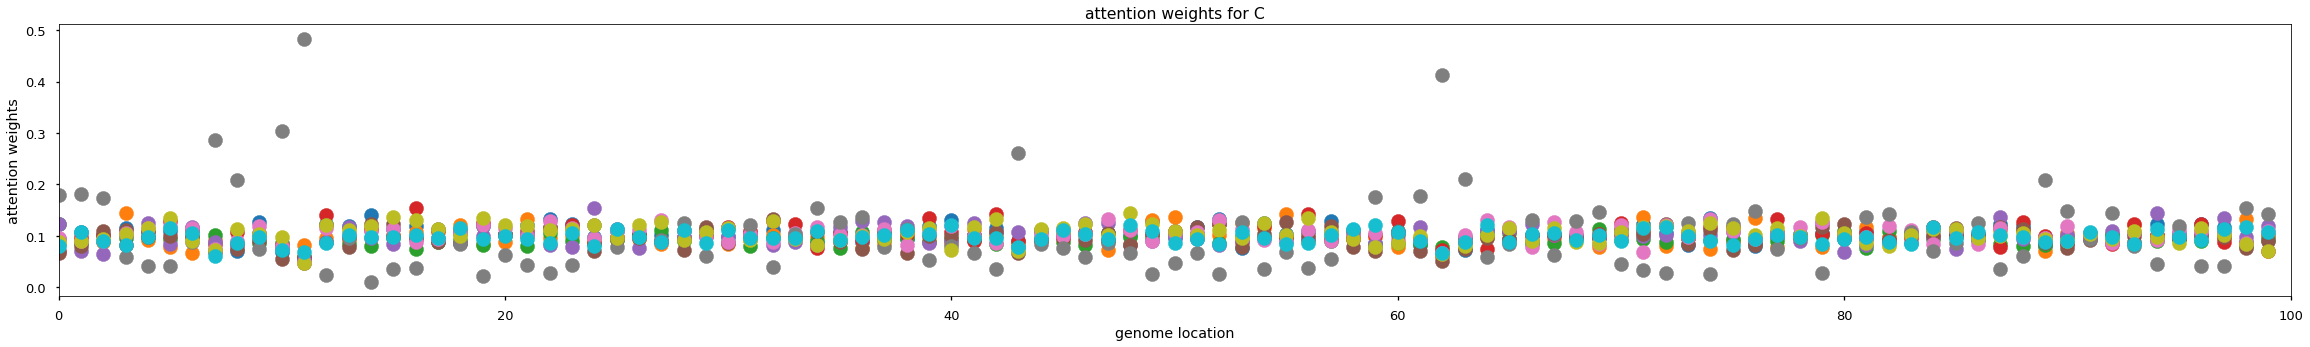

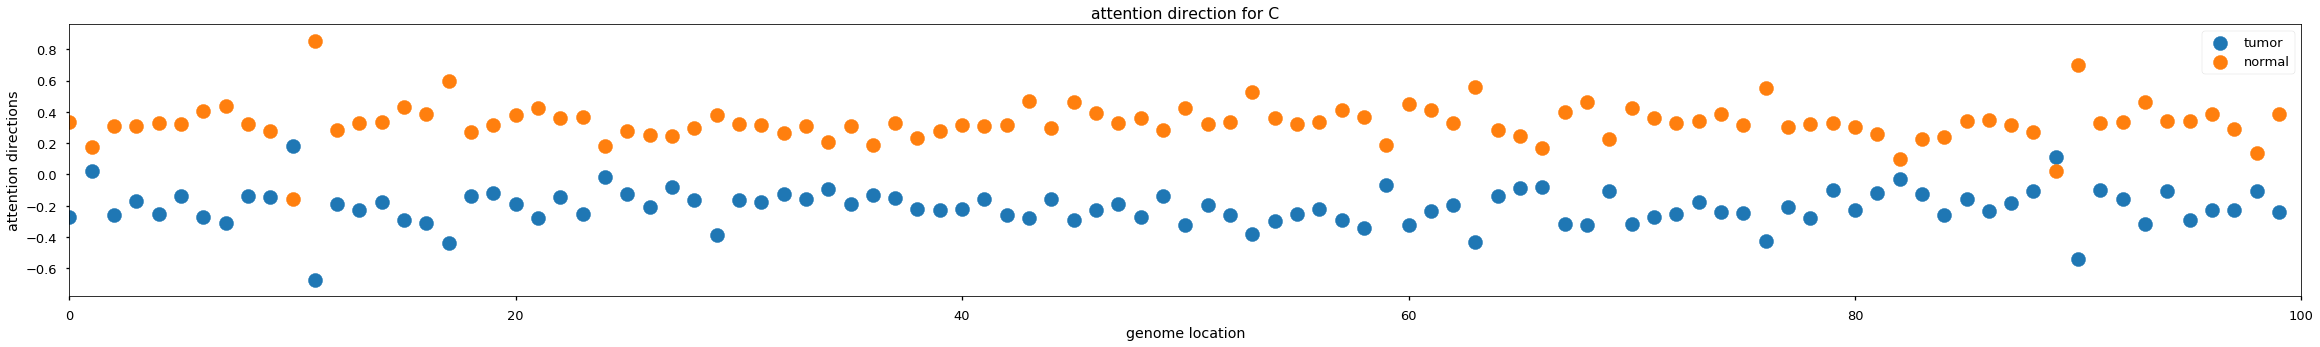

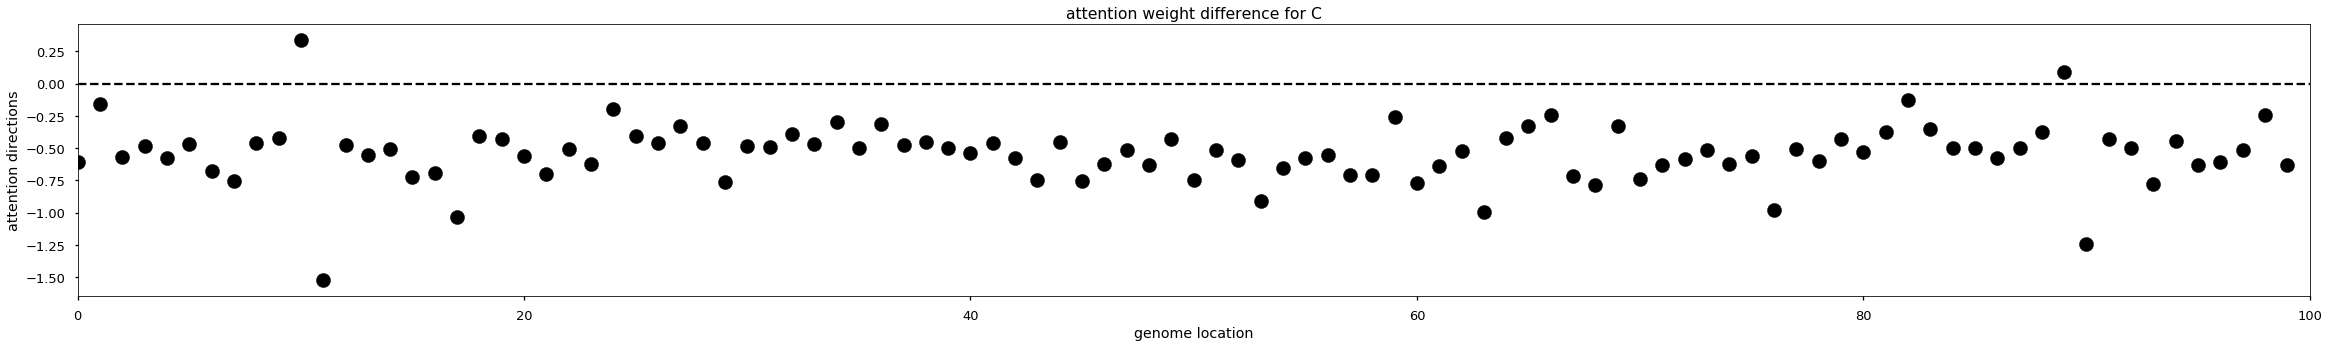

In [60]:
K_lookup_C = model.K(genome_C) 
V_lookup_C = model.V(genome_C) 
logits_C = model.Q(K_lookup_C) / math.sqrt(model.embedding_size)
probs_C = F.softmax(logits_C, dim = -1)    
X_C = probs_C * V_lookup_C
Y_C = model.W(X_C)

print(probs_C.shape)
print(Y_C.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_C.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for C')
plt.savefig('./C-attn-'+file_name+'.png')
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for C')
plt.savefig('./C-dirc-'+file_name+'.png')
plt.show()


plt.scatter(np.arange(GENOME_LENGTH), Y_C.data[:,0]-Y_C.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for C')
plt.axhline(y=0,ls='dashed',c='black')
plt.savefig('./C-diff-'+file_name+'.png')
plt.show()

torch.Size([100, 10])
torch.Size([100, 2])


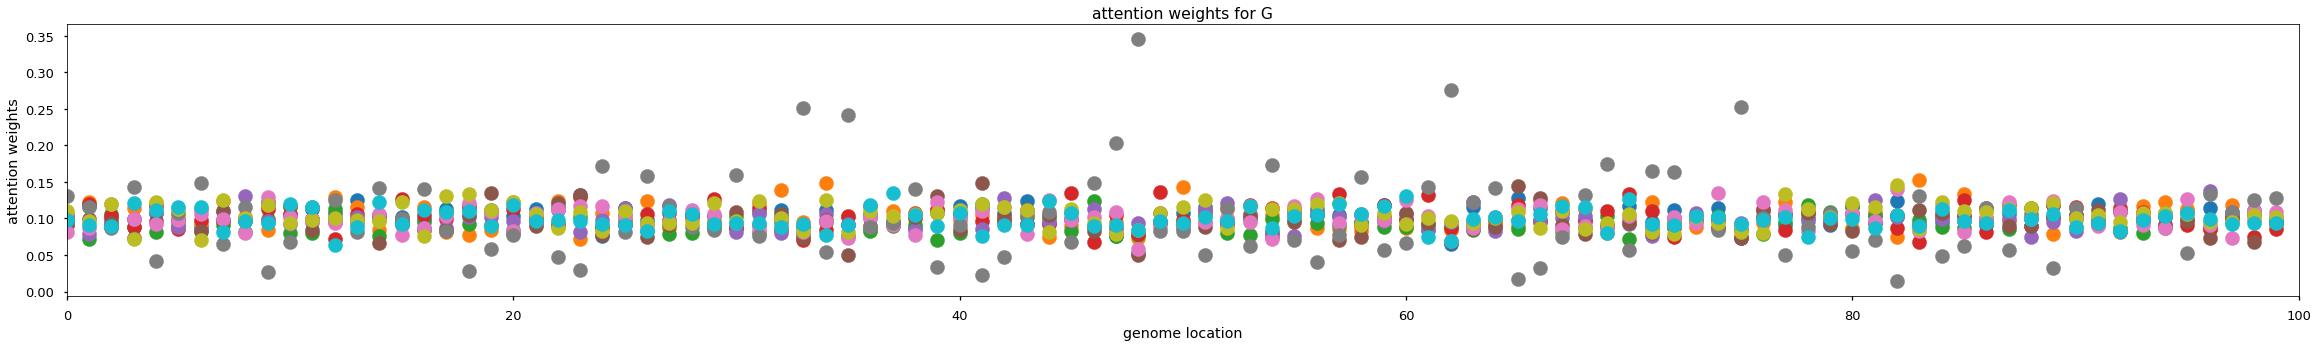

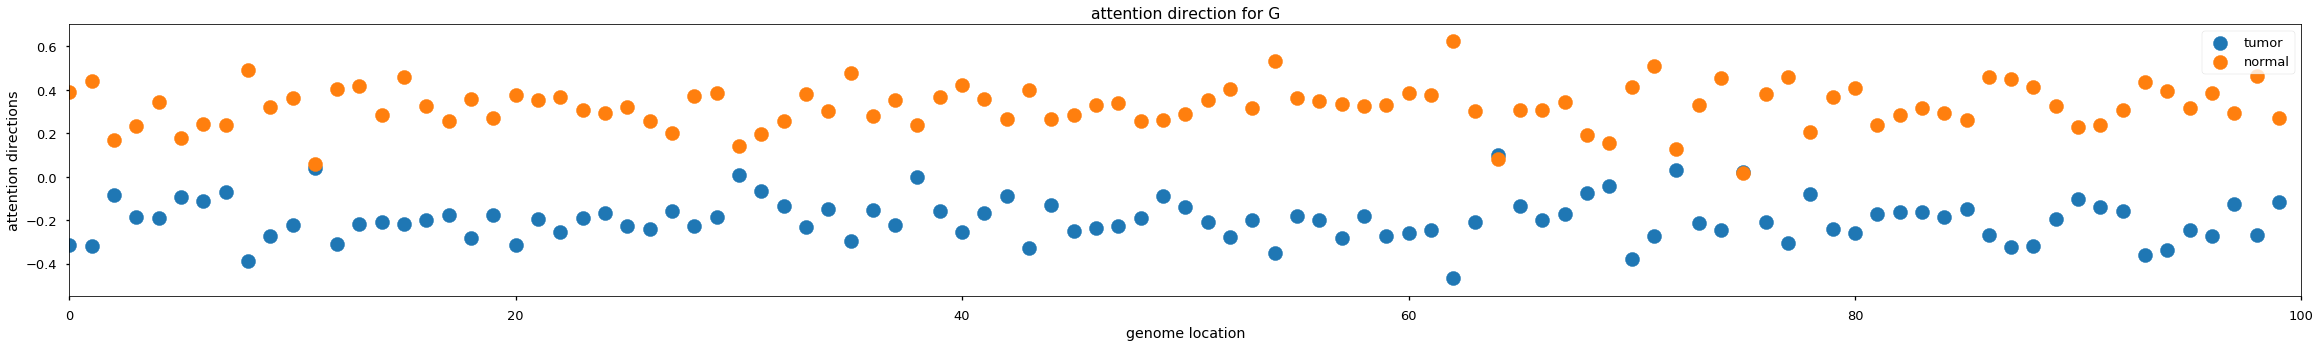

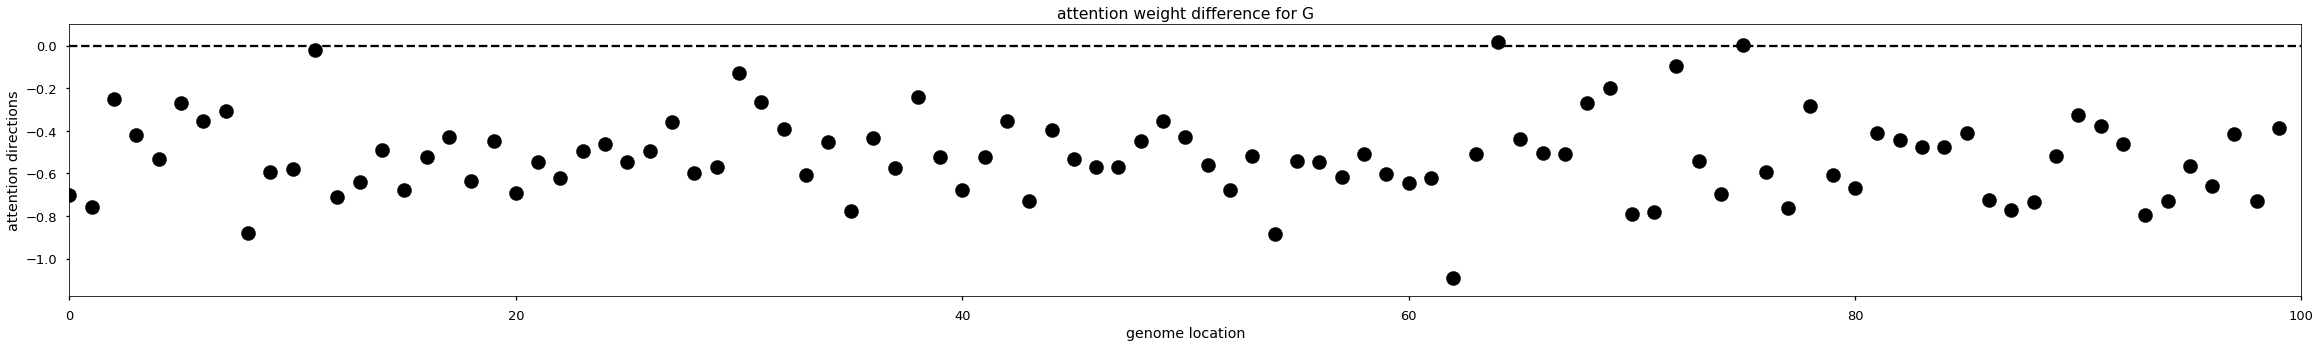

In [61]:
K_lookup_G = model.K(genome_G) 
V_lookup_G = model.V(genome_G) 
logits_G = model.Q(K_lookup_G) / math.sqrt(model.embedding_size)
probs_G = F.softmax(logits_G, dim = -1)    
X_G = probs_G * V_lookup_G
Y_G = model.W(X_G)

print(probs_G.shape)
print(Y_G.shape)

for q in range(q_size):
    plt.scatter(np.arange(GENOME_LENGTH), probs_G.data[:,q], s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention weights')
plt.title('attention weights for G')
plt.savefig('./G-attn-'+file_name+'.png')
plt.show()

for q in range(2):
    plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,q], s=point_size, alpha=alpha_value)
plt.legend({'normal','tumor'})
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention direction for G')
plt.savefig('./G-dirc-'+file_name+'.png')
plt.show()

plt.scatter(np.arange(GENOME_LENGTH), Y_G.data[:,0]-Y_G.data[:,1], c='black', s=point_size, alpha=alpha_value)
plt.rcParams['figure.figsize'] = [width, height]
plt.xlim(0, GENOME_LENGTH)
plt.xlabel('genome location')
plt.ylabel('attention directions')
plt.title('attention weight difference for G')
plt.axhline(y=0,ls='dashed',c='black')
plt.savefig('./G-diff-'+file_name+'.png')
plt.show()